In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os

from matplotlib.sankey import Sankey
import plotly.graph_objects as go


In [2]:
current_dir = os.getcwd()
datapath = os.path.join(current_dir, "../..", 'data/outputs/DES_data.csv')

df = pd.read_csv(datapath, sep=',', index_col='date')
df.index = pd.to_datetime(df.index)
print(df.head())

                     PVSim-0.PV_0-P[MW]  CSV-0.DNI_0-DNI  \
date                                                       
2022-01-01 00:00:00                 0.0           -0.991   
2022-01-01 00:01:00                 0.0           -0.991   
2022-01-01 00:02:00                 0.0           -0.991   
2022-01-01 00:03:00                 0.0           -0.991   
2022-01-01 00:04:00                 0.0           -0.991   

                     CSV-1.HEATLOAD_0-T_amb  HeatPumpSim-0.HeatPump_0-T_amb  \
date                                                                          
2022-01-01 00:00:00                   6.855                           0.000   
2022-01-01 00:01:00                   6.855                           6.855   
2022-01-01 00:02:00                   6.855                           6.855   
2022-01-01 00:03:00                   6.855                           6.855   
2022-01-01 00:04:00                   6.855                           6.855   

                     CSV-

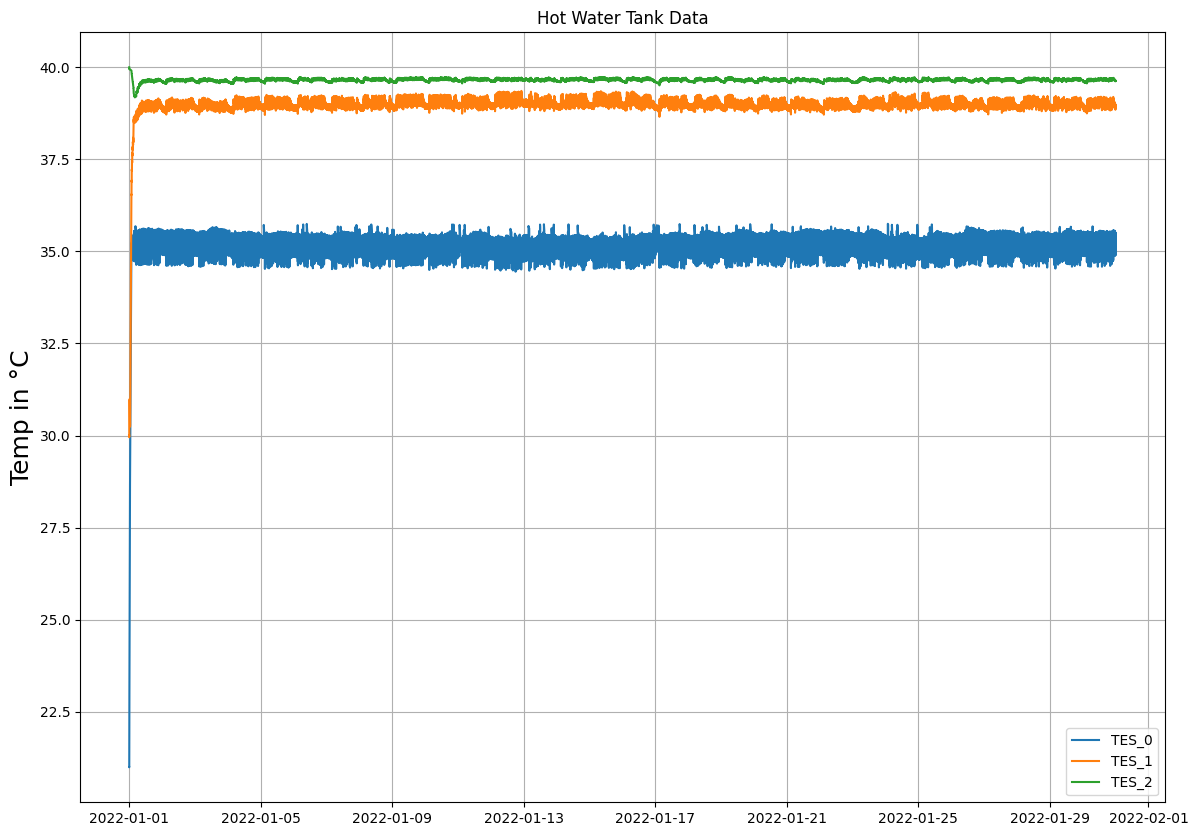

In [3]:
hot_water_tank_columns = [col for col in df.columns if col.startswith('HotWaterTankSim-0.HotWaterTank_0-sensor')] # hwts1


plt.figure(figsize=(14, 10))
plt.plot(df[hot_water_tank_columns], label=['TES_0', 'TES_1', 'TES_2'])
# plt.plot(df['HotWaterTankSim-0.HotWaterTank_0-hp_out.T'], color='orange')
# 
# plt.plot(df['CHPSim-0.CHP_0-temp_out'], color='red', label='CHP out temp')
# plt.plot(df['HotWaterTankSim-0.HotWaterTank_0-hp_in.T'], color='blue', label='HP output')
# plt.plot(df['HeatPumpSim-0.HeatPump_0-heat_source_T'], color='red', label='heat source temp')
# plt.plot(df['ControllerSim-0.Controller_0-dhw_in_T'], color='red', label='DHW in T')
plt.ylabel('Temp in °C', fontsize=18)
plt.title('Hot Water Tank Data')
plt.grid()
plt.legend()
plt.show()

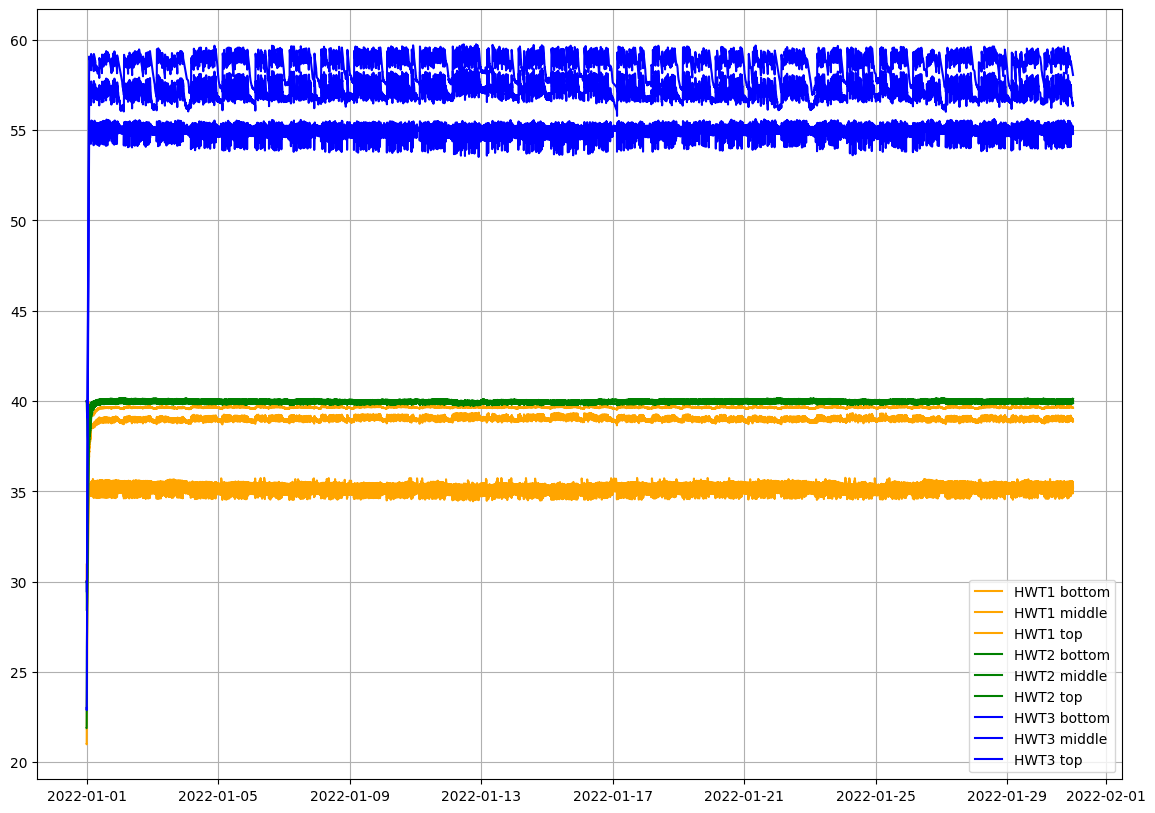

In [4]:
hwt1_cols = [col for col in df.columns if col.startswith('HotWaterTankSim-0.HotWaterTank_0-sensor')]
hwt2_cols = [col for col in df.columns if col.startswith('HotWaterTankSim-1.HotWaterTank_0-sensor')]
hwt3_cols = [col for col in df.columns if col.startswith('HotWaterTankSim-2.HotWaterTank_0-sensor')]

plt.figure(figsize=(14, 10))
plt.plot(df[hwt1_cols], label=['HWT1 bottom', 'HWT1 middle', 'HWT1 top'], color = 'orange')
plt.plot(df[hwt2_cols], label=['HWT2 bottom', 'HWT2 middle', 'HWT2 top'], color = 'green')
plt.plot(df[hwt3_cols], label=['HWT3 bottom', 'HWT3 middle', 'HWT3 top'], color = 'blue')

plt.grid()
plt.legend()
plt.show()

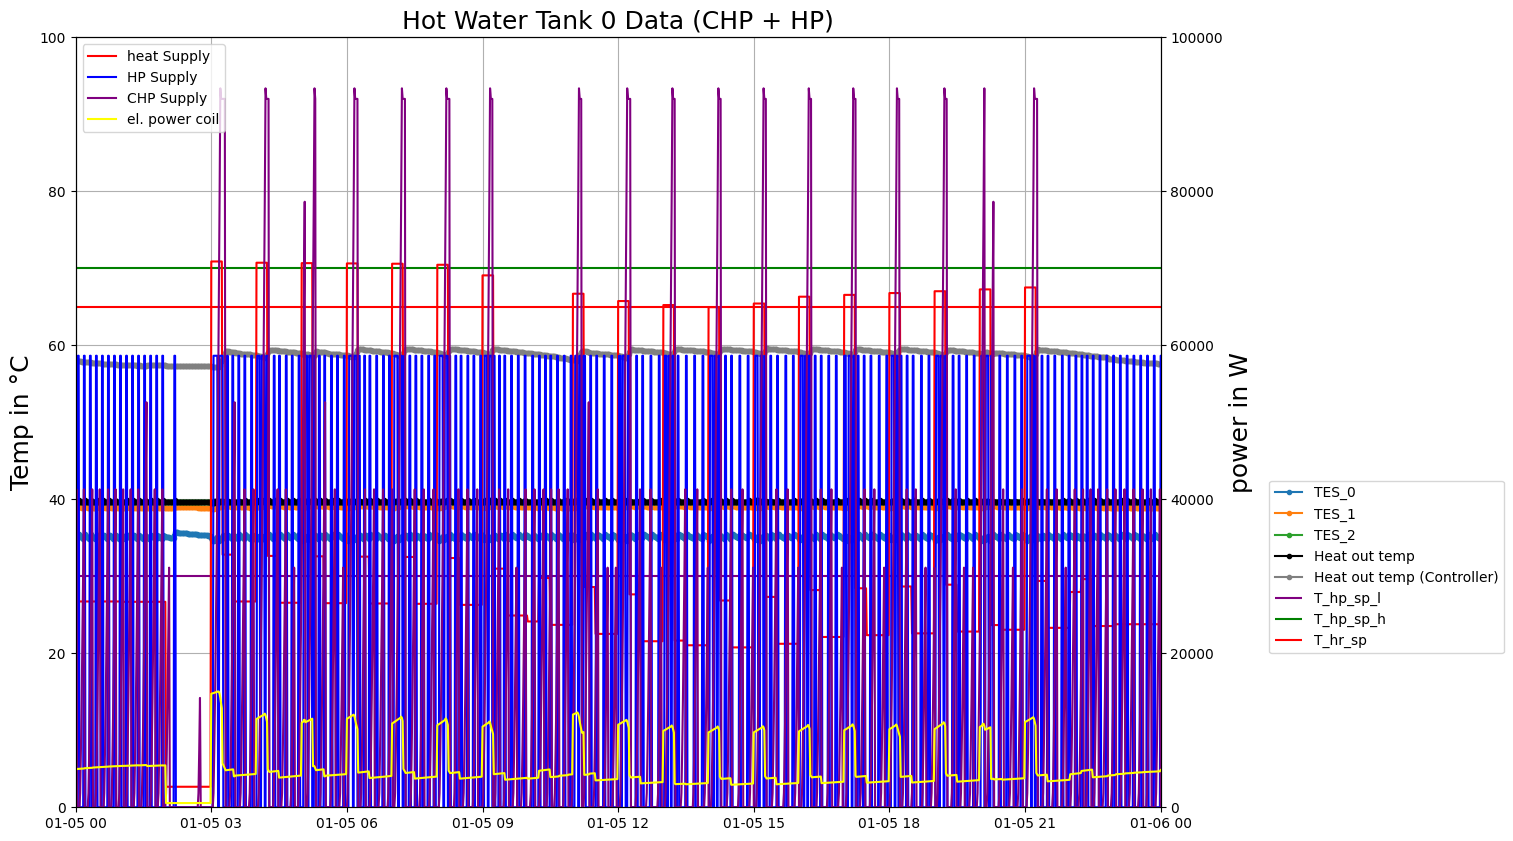

In [5]:
params_ctrl = {
    'T_hp_sp_h': 70,
    'T_hp_sp_l': 30,
    'T_hr_sp': 65,
    'operation_mode': 'heating',
    'control_strategy': '3'
}

hot_water_tank_columns = [col for col in df.columns if col.startswith('HotWaterTankSim-0.HotWaterTank_0-sensor')]

plt.figure(figsize=(14, 10))

# Plotting the hot water tank data
plt.plot(df[hot_water_tank_columns], label=['TES_0', 'TES_1', 'TES_2'], marker='.')
plt.plot(df['HotWaterTankSim-0.HotWaterTank_0-heat_out.T'], color='black', label='Heat out temp', marker='.')
plt.plot(df['ControllerSim-0.Controller_0-heat_out_T'], color='grey', label='Heat out temp (Controller)', marker='.')

# Plotting horizontal lines
plt.hlines(params_ctrl['T_hp_sp_l'], 1000, 9999999, label='T_hp_sp_l', color='purple')
plt.hlines(params_ctrl['T_hp_sp_h'], 1000, 9999999, label='T_hp_sp_h', color='green')
plt.hlines(params_ctrl['T_hr_sp'], 1000, 9999999, label='T_hr_sp', color='red')


# Primary y-axis
plt.ylabel('Temp in °C', fontsize=18)
plt.title('Hot Water Tank 0 Data (CHP + HP)', fontsize=18)
plt.grid()
plt.xlim([datetime.date(2022, 1, 5), datetime.date(2022, 1, 6)])
plt.ylim(0,100)
plt.legend(loc=(1.1, 0.2))

# Create secondary y-axis for sh_demand
ax2 = plt.gca().twinx()
ax2.plot(df.index, df['ControllerSim-0.Controller_0-heat_demand'], color='red', label='heat Supply')
ax2.plot(df.index, df['ControllerSim-0.Controller_0-hp_supply'], color='blue', label='HP Supply')
ax2.plot(df.index, df['ControllerSim-0.Controller_0-chp_supply'], color='purple', label='CHP Supply')
ax2.plot(df.index, df['ControllerSim-0.Controller_0-P_hr'], color='yellow', label='el. power coil')
ax2.set_ylabel('power in W', fontsize=18)
ax2.tick_params(axis='y')
ax2.set_ylim(0,100_000)

# Combining legends from both axes
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(labels + labels2, loc='upper left')

plt.show()

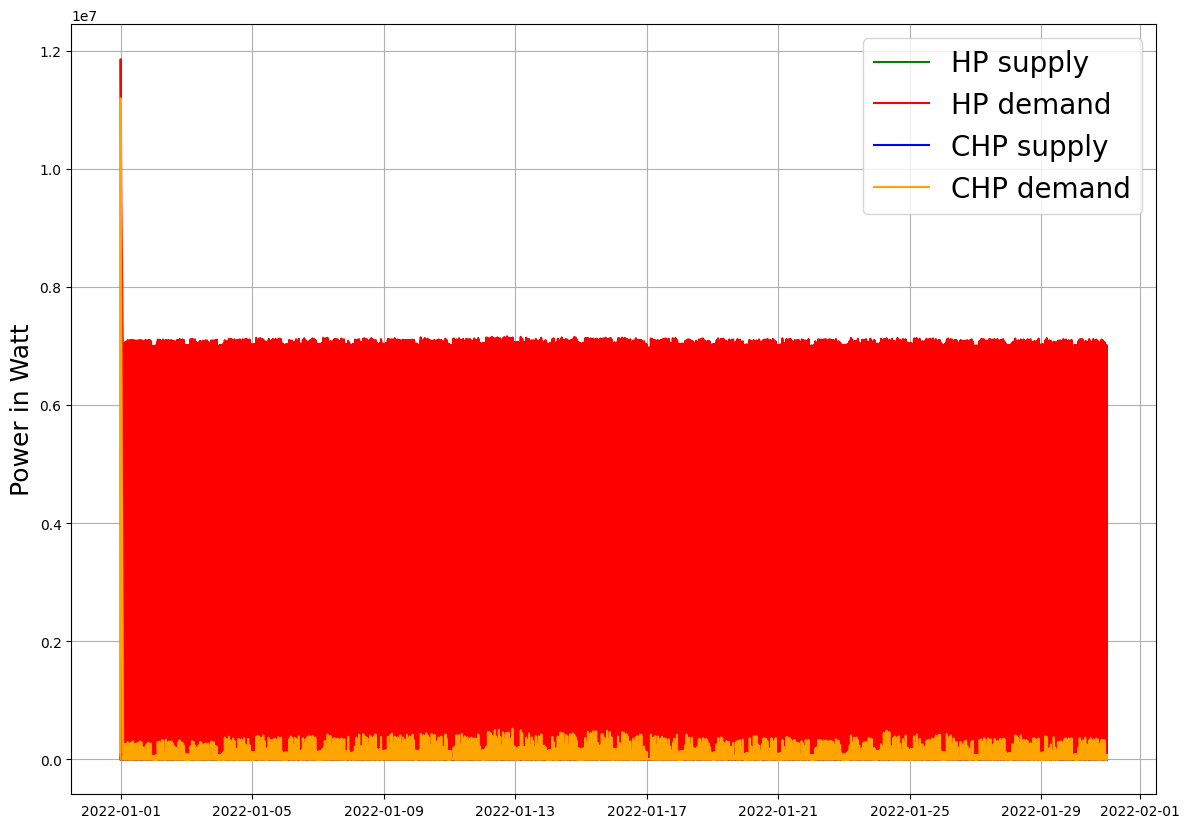

In [6]:
plt.figure(figsize=(14, 10))
# plt.plot(df['ControllerSim-0.Controller_0-heat_supply'], color='blue', label='heat supply')
plt.plot(df['ControllerSim-0.Controller_0-hp_supply'], color='green', label='HP supply')
plt.plot(df['ControllerSim-0.Controller_0-hp_demand'], color='red', label='HP demand')
plt.plot(df['ControllerSim-0.Controller_0-chp_supply'], color='blue', label='CHP supply')
plt.plot(df['ControllerSim-0.Controller_0-chp_demand'], color='orange', label='CHP demand')

# plt.plot(df['CHPSim-0.CHP_0-Q_Demand'], color='red', label='CHP demand')
# plt.yticks(fontsize=20)
plt.ylabel('Power in Watt', fontsize=18)
# plt.title('Energy flows', fontsize=30, y=1.05)
plt.grid()
plt.legend(fontsize=20)
plt.show()

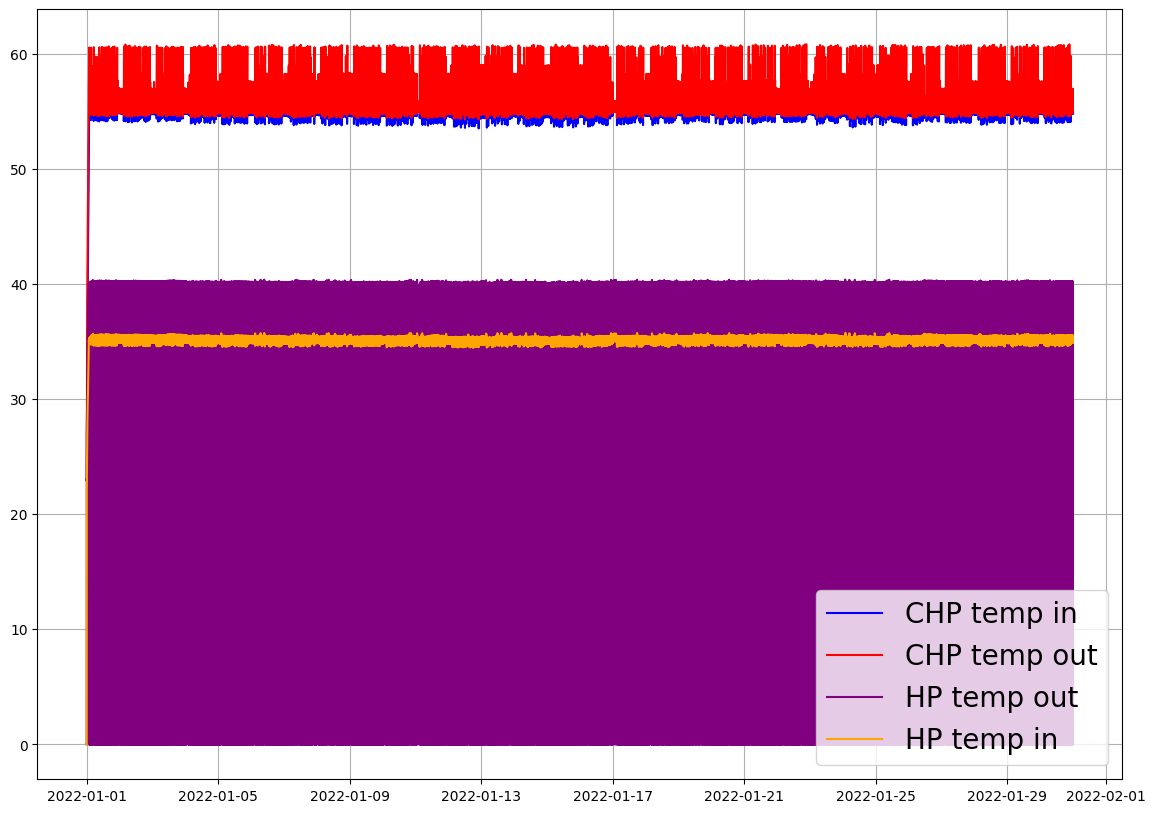

In [7]:
plt.figure(figsize=(14, 10))
plt.plot(df['CHPSim-0.CHP_0-temp_in'], color='blue', label='CHP temp in')
plt.plot(df['CHPSim-0.CHP_0-temp_out'], color='red', label='CHP temp out')
plt.plot(df['HeatPumpSim-0.HeatPump_0-cons_T'], color='purple', label='HP temp out')
plt.plot(df['HeatPumpSim-0.HeatPump_0-cond_in_T'], color='orange', label='HP temp in')

plt.grid()
plt.legend(fontsize=20)
plt.show()

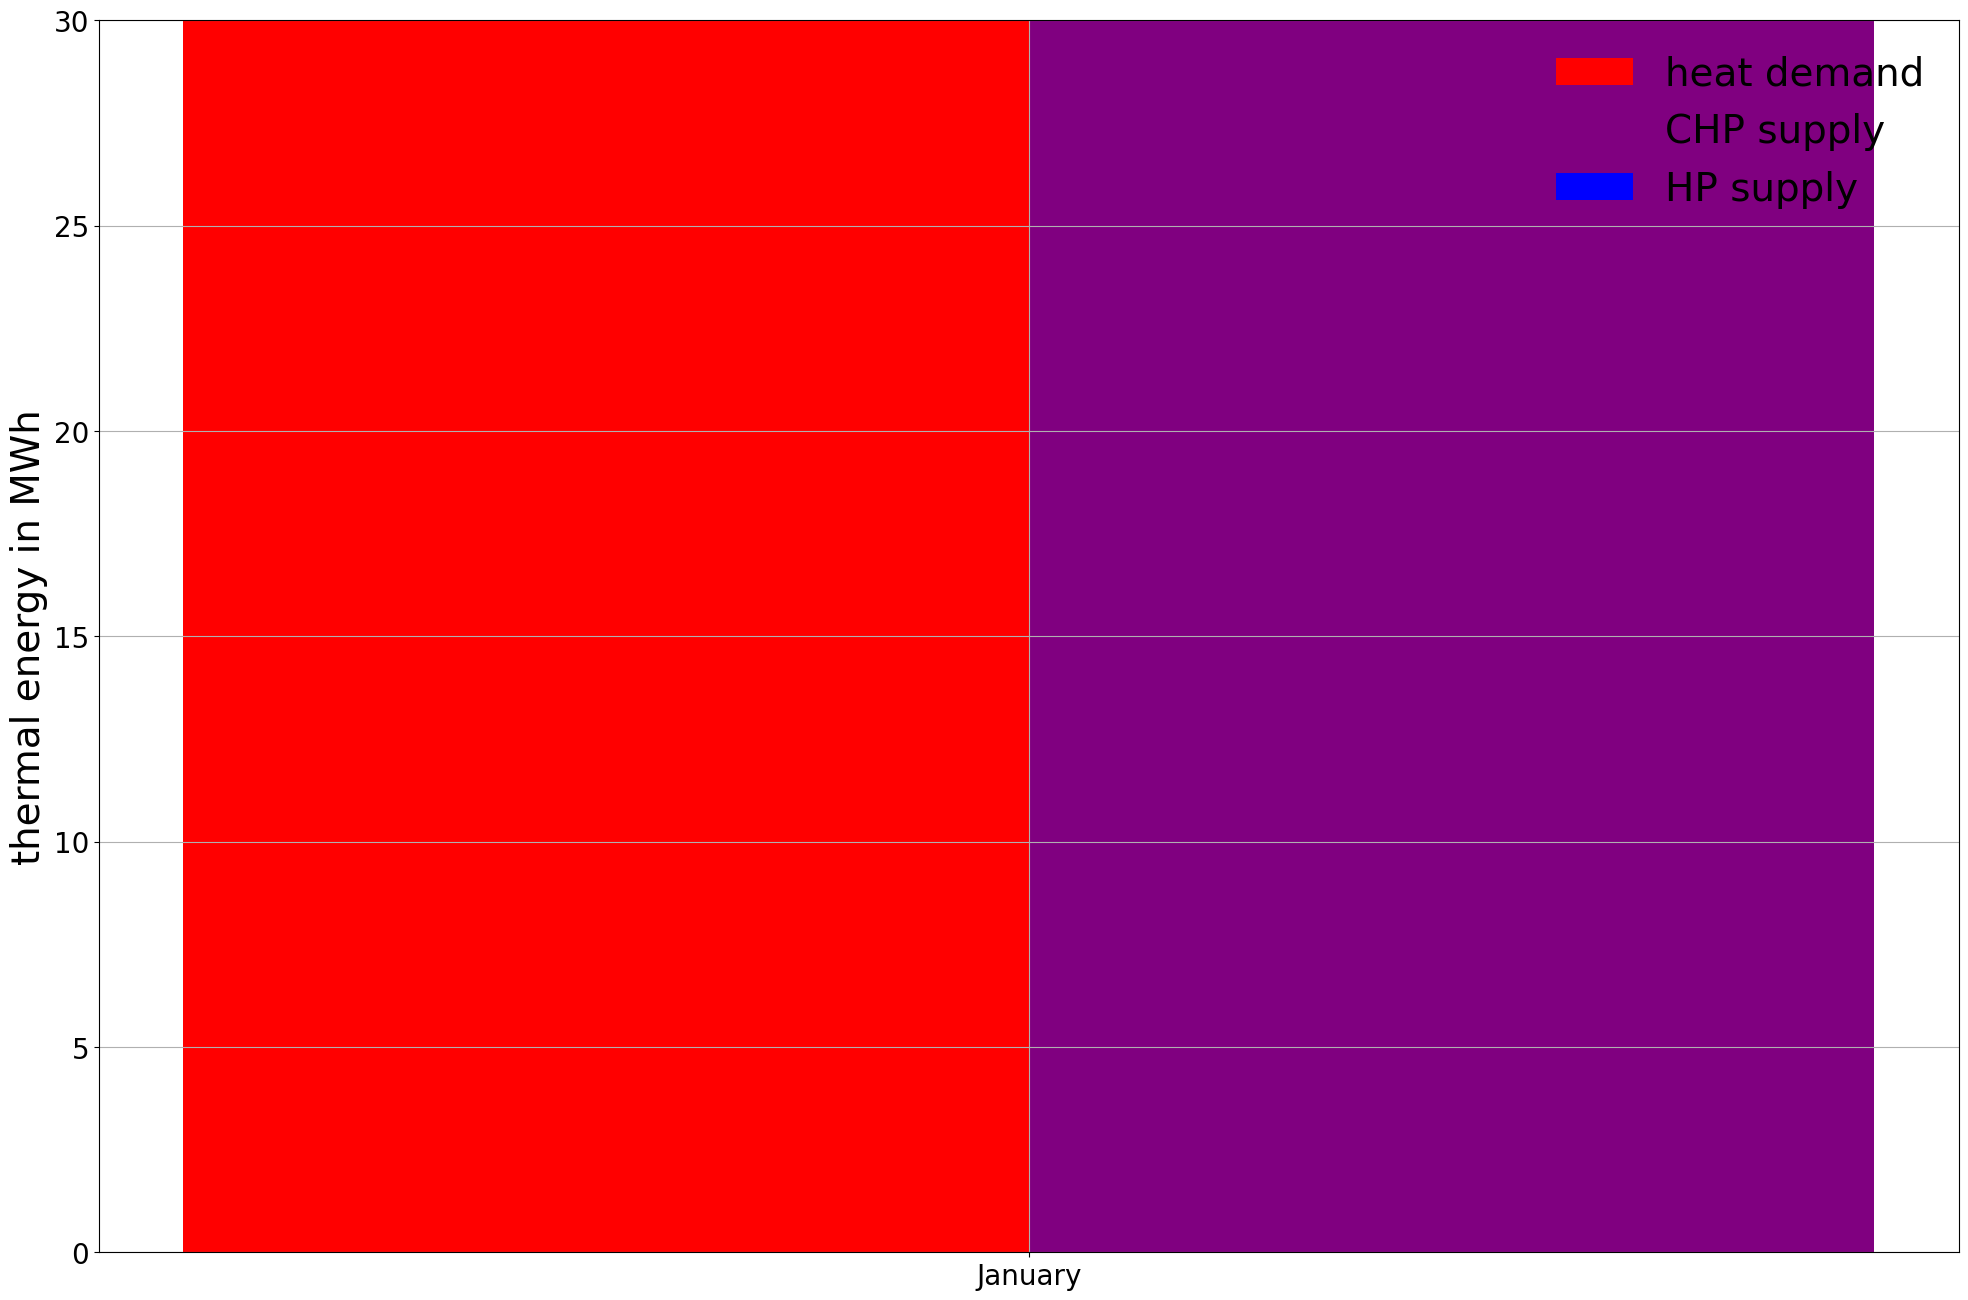

In [8]:
df_monthly = df.resample('M').sum()/4

# Generate the positions for the bars
months = df_monthly.index.month_name()
x = np.arange(len(months))  # the label locations
width = 0.35  # the width of the bars

# Create the figure and the bar plots
plt.figure(figsize=(24, 16))

# Plot heat demand on the left
plt.bar(
    x - width/2, 
    df_monthly['ControllerSim-0.Controller_0-heat_demand']/1_000_000, 
    width=width, 
    color='red', 
    label='heat demand', 
)

# Plot CHP supply stacked with HP supply on the right
plt.bar(
    x + width/2, 
    df_monthly['ControllerSim-0.Controller_0-chp_supply']/1_000_000, 
    width=width, 
    color='purple', 
    label='CHP supply', 
)
plt.bar(
    x + width/2, 
    df_monthly['ControllerSim-0.Controller_0-hp_supply']/1_000_000, 
    width=width, 
    color='blue', 
    label='HP supply', 
    bottom=df_monthly['ControllerSim-0.Controller_0-chp_supply']/1_000_000
)

# Set x-ticks and labels
plt.xticks(x, months, fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('thermal energy in MWh', fontsize=28)
plt.ylim(0,30)
plt.grid()

# Set the legend
plt.legend(fontsize=28, frameon=False)

# Display the plot
plt.show()

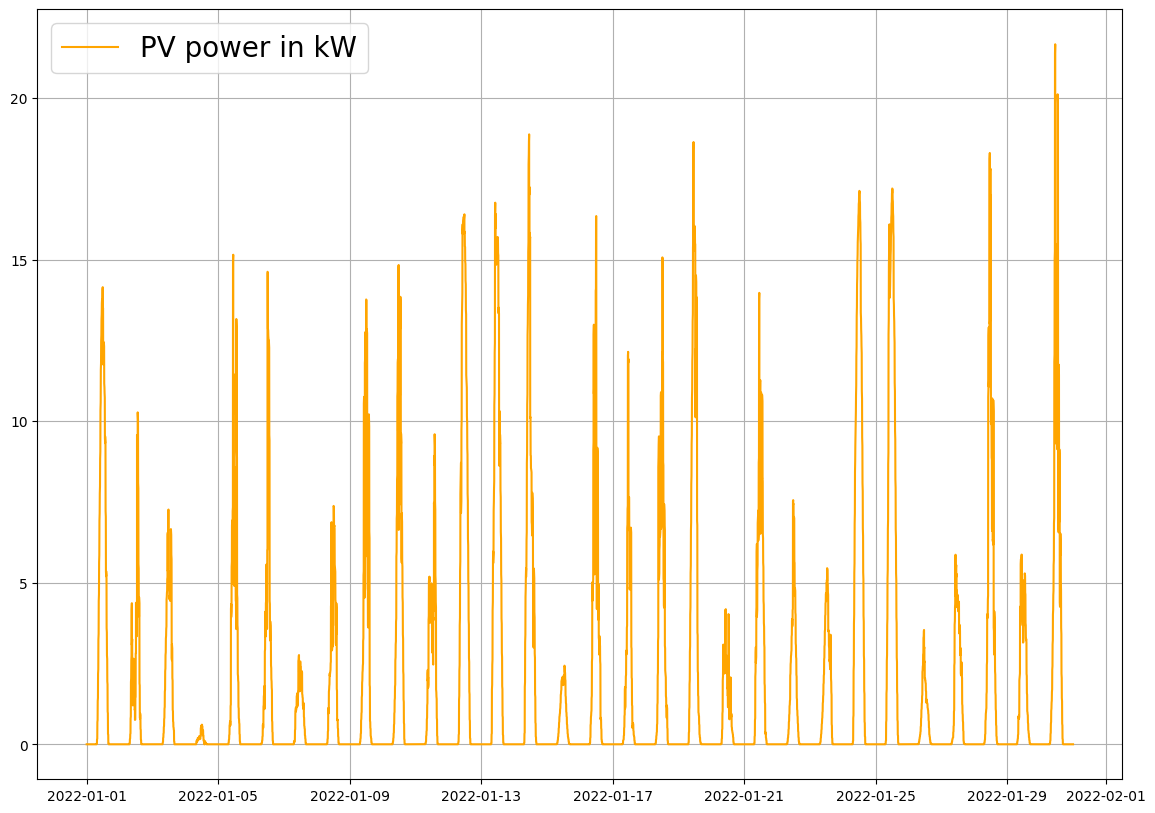

In [9]:
plt.figure(figsize=(14, 10))

plt.plot(df['PVSim-0.PV_0-P[MW]']*1000, color='orange', label='PV power in kW')
# plt.title('Energy flows', fontsize=30, y=1.05)
plt.grid()
plt.legend(fontsize=20)
plt.show()


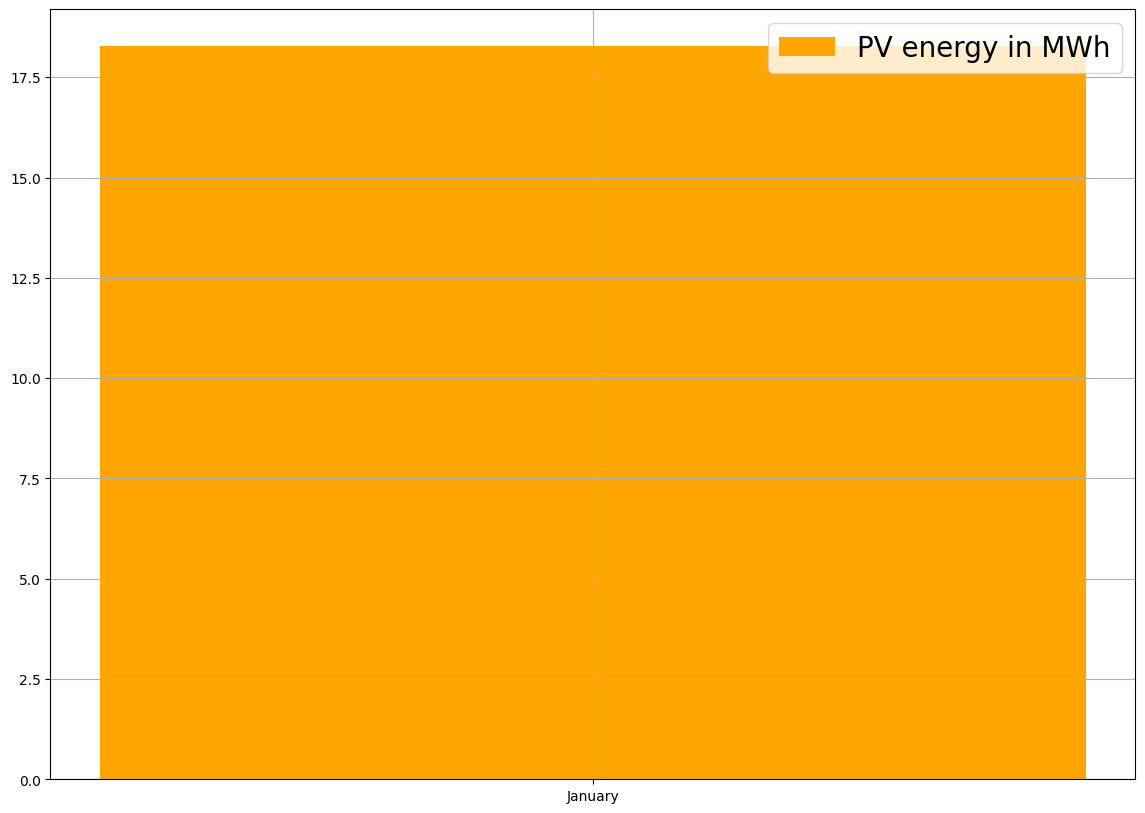

In [10]:
plt.figure(figsize=(14, 10))

plt.bar(months, df_monthly['PVSim-0.PV_0-P[MW]'], color='orange', label='PV energy in MWh')
# plt.title('Energy flows', fontsize=30, y=1.05)
plt.grid()
plt.legend(fontsize=20)
plt.show()

In [11]:
columnname = {'PVSim-0.PV_0-P[MW]': 'PV_P[MW]', 'CSV-0.DNI_0-DNI': 'DNI', 'CSV-1.HEATLOAD_0-T_amb':'T_amb', 'HeatPumpSim-0.HeatPump_0-T_amb' : 'HP_Tamb', 'CSV-1.HEATLOAD_0-Heat Demand [kW]':'Heat Demand [KW]',
       'HeatPumpSim-0.HeatPump_0-Q_Demand' : 'HP_Q_Demand', 'CHPSim-0.CHP_0-Q_Demand':'CHP_Q_Demand',
       'HeatPumpSim-0.HeatPump_0-Q_Supplied' : 'HP_Q_Supplied',
       'HeatPumpSim-0.HeatPump_0-heat_source_T' : 'HP_heat_sourceT',
       'HeatPumpSim-0.HeatPump_0-cons_T' : 'HP_consT',
       'HeatPumpSim-0.HeatPump_0-P_Required': 'HP_P_Required', 'HeatPumpSim-0.HeatPump_0-COP':'HP_COP',
       'HeatPumpSim-0.HeatPump_0-cond_m':'HP_cond_m', 'HeatPumpSim-0.HeatPump_0-cond_in_T':'HP_cond_in_T',
       'HeatPumpSim-0.HeatPump_0-on_fraction':'HP_onfraction',
       'ControllerSim-0.Controller_0-heat_demand':'heat_demand',
       'ControllerSim-0.Controller_0-heat_supply':'heat_supply',
       'ControllerSim-0.Controller_0-hp_demand':'hp_demand',
       'ControllerSim-0.Controller_0-hp_supply':'hp_supply',
       'ControllerSim-0.Controller_0-chp_demand':'chp_demand',
       'ControllerSim-0.Controller_0-chp_supply':'chp_supply',
       'ControllerSim-0.Controller_0-heat_in_F':'heatin_F',
       'ControllerSim-0.Controller_0-heat_in_T':'heatin_T',
       'ControllerSim-0.Controller_0-heat_out_F':'heatout_F',
       'ControllerSim-0.Controller_0-heat_out_T':'heatout_T',
       'ControllerSim-0.Controller_0-chp_in_F':'chpin_F',
       'ControllerSim-0.Controller_0-chp_in_T':'chpin_T',
       'ControllerSim-0.Controller_0-chp_out_F':'chpout_F',
       'ControllerSim-0.Controller_0-chp_out_T':'chpout_T',
       'ControllerSim-0.Controller_0-hp_out_F':'hpout_F',
       'ControllerSim-0.Controller_0-hp_out_T':'hpout_T',
       'ControllerSim-0.Controller_0-P_hr':'P_hr',
       'HotWaterTankSim-0.HotWaterTank_0-sensor_00.T':'HWTSim0_sensor0_T',
       'HotWaterTankSim-1.HotWaterTank_0-sensor_00.T':'HWTSim1_sensor0_T',
       'HotWaterTankSim-2.HotWaterTank_0-sensor_00.T':'HWTSim2_sensor0_T',
       'HotWaterTankSim-0.HotWaterTank_0-sensor_01.T':'HWTSim0_sensor1_T',
       'HotWaterTankSim-1.HotWaterTank_0-sensor_01.T':'HWTSim1_sensor1_T',
       'HotWaterTankSim-2.HotWaterTank_0-sensor_01.T':'HWTSim2_sensor1_T',
       'HotWaterTankSim-0.HotWaterTank_0-sensor_02.T':'HWTSim0_sensor2_T',
       'HotWaterTankSim-1.HotWaterTank_0-sensor_02.T':'HWTSim1_sensor2_T',
       'HotWaterTankSim-2.HotWaterTank_0-sensor_02.T':'HWTSim2_sensor2_T',
       'HotWaterTankSim-0.HotWaterTank_0-heat_out.T':'HWTSim0_heatout_T',
       'HotWaterTankSim-1.HotWaterTank_0-heat_out.T':'HWTSim1_heatout_T',
       'HotWaterTankSim-2.HotWaterTank_0-heat_out.T':'HWTSim2_heatout_T',
       'HotWaterTankSim-0.HotWaterTank_0-heat_out.F':'HWTSim0_heatout_F',
       'HotWaterTankSim-1.HotWaterTank_0-heat_out.F':'HWTSim1_heatout_F',
       'HotWaterTankSim-2.HotWaterTank_0-heat_out.F':'HWTSim2_heatout_F',
       'HotWaterTankSim-0.HotWaterTank_0-hp_in.T':'HWTSim0_hp_in_T',
       'HotWaterTankSim-1.HotWaterTank_0-hp_in.T':'HWTSim1_hp_in_T',
       'HotWaterTankSim-2.HotWaterTank_0-hp_in.T':'HWTSim2_hp_in_T',
       'HotWaterTankSim-0.HotWaterTank_0-hp_in.F':'HWTSim0_hp_in_F',
       'HotWaterTankSim-1.HotWaterTank_0-hp_in.F':'HWTSim1_hp_in_F',
       'HotWaterTankSim-2.HotWaterTank_0-hp_in.F':'HWTSim2_hp_in_F',
       'HotWaterTankSim-0.HotWaterTank_0-hp_out.T':'HWTSim0_hp_out_T',
       'HotWaterTankSim-1.HotWaterTank_0-hp_out.T':'HWTSim1_hp_out_T',
       'HotWaterTankSim-2.HotWaterTank_0-hp_out.T':'HWTSim2_hp_out_T',
       'HotWaterTankSim-0.HotWaterTank_0-hp_out.F':'HWTSim0_hp_out_F',
       'HotWaterTankSim-1.HotWaterTank_0-hp_out.F':'HWTSim1_hp_out_F',
       'HotWaterTankSim-2.HotWaterTank_0-hp_out.F':'HWTSim2_hp_out_F',
       'HotWaterTankSim-0.HotWaterTank_0-heat_in.T':'HWTSim0_heatin_T',
       'HotWaterTankSim-1.HotWaterTank_0-heat_in.T':'HWTSim1_heatin_T',
       'HotWaterTankSim-2.HotWaterTank_0-heat_in.T':'HWTSim2_heatin_T',
       'HotWaterTankSim-0.HotWaterTank_0-heat_in.F':'HWTSim0_heatin_F',
       'HotWaterTankSim-1.HotWaterTank_0-heat_in.F':'HWTSim1_heatin_F',
       'HotWaterTankSim-2.HotWaterTank_0-heat_in.F':'HWTSim2_heatin_F',
       'HotWaterTankSim-0.HotWaterTank_0-T_mean':'HWTSim0_Tmean',
       'HotWaterTankSim-1.HotWaterTank_0-T_mean':'HWTSim1_Tmean',
       'HotWaterTankSim-2.HotWaterTank_0-T_mean':'HWTSim2_Tmean', 'CHPSim-0.CHP_0-eff_el':'CHP_eff',
       'CHPSim-0.CHP_0-nom_P_th':'CHP_nom_Pth', 'CHPSim-0.CHP_0-mdot':'CHP_mdot',
       'CHPSim-0.CHP_0-mdot_neg':'CHP_mdot_neg', 'CHPSim-0.CHP_0-temp_in':'CHP_tempin',
       'CHPSim-0.CHP_0-temp_out':'CHP_tempout', 'CHPSim-0.CHP_0-P_th':'CHP_Pth', 'HeatPumpSim-0.HeatPump_0-Q_evap' : 'HP_Q_Evap'}

In [12]:
oldcolumns = df.columns
column_translate = np.asarray(list(columnname.keys()))

n = np.setdiff1d(oldcolumns,column_translate)  
print(f'translation not defined for :\n {n}') 

df.rename(columns = columnname, inplace = True)
# df.head()
print(f'{len(df.columns)-len(columnname.keys())} columns were not translated!')

columnnew = df.columns
targetcolumn = np.asarray(list(columnname.values()))
for i,j in zip(columnnew, targetcolumn):
    if not i == j:

        print(f'{j} not translated\n')

translation not defined for :
 ['CHPSim-0.CHP_0-P_el']
1 columns were not translated!
heat_demand not translated

heat_supply not translated

hp_demand not translated

hp_supply not translated

chp_demand not translated

chp_supply not translated

heatin_F not translated

heatin_T not translated

heatout_F not translated

heatout_T not translated

chpin_F not translated

chpin_T not translated

chpout_F not translated

chpout_T not translated

hpout_F not translated

hpout_T not translated

P_hr not translated

HWTSim0_sensor0_T not translated

HWTSim1_sensor0_T not translated

HWTSim2_sensor0_T not translated

HWTSim0_sensor1_T not translated

HWTSim1_sensor1_T not translated

HWTSim2_sensor1_T not translated

HWTSim0_sensor2_T not translated

HWTSim1_sensor2_T not translated

HWTSim2_sensor2_T not translated

HWTSim0_heatout_T not translated

HWTSim1_heatout_T not translated

HWTSim2_heatout_T not translated

HWTSim0_heatout_F not translated

HWTSim1_heatout_F not translated

HWTSim2

In [13]:
pd.set_option('display.max_columns', None)
df.head()

,PV_P[MW],DNI,T_amb,HP_Tamb,Heat Demand [KW],HP_Q_Demand,CHP_Q_Demand,HP_Q_Supplied,HP_heat_sourceT,HP_consT,HP_P_Required,HP_COP,HP_cond_m,HP_cond_in_T,HP_onfraction,HP_Q_Evap,heat_demand,heat_supply,hp_demand,hp_supply,chp_demand,chp_supply,heatin_F,heatin_T,heatout_F,heatout_T,chpin_F,chpin_T,chpout_F,chpout_T,hpout_F,hpout_T,P_hr,HWTSim0_sensor0_T,HWTSim1_sensor0_T,HWTSim2_sensor0_T,HWTSim0_sensor1_T,HWTSim1_sensor1_T,HWTSim2_sensor1_T,HWTSim0_sensor2_T,HWTSim1_sensor2_T,HWTSim2_sensor2_T,HWTSim0_heatout_T,HWTSim1_heatout_T,HWTSim2_heatout_T,HWTSim0_heatout_F,HWTSim1_heatout_F,HWTSim2_heatout_F,HWTSim0_hp_in_T,HWTSim1_hp_in_T,HWTSim2_hp_in_T,HWTSim0_hp_in_F,HWTSim1_hp_in_F,HWTSim2_hp_in_F,HWTSim0_hp_out_T,HWTSim1_hp_out_T,HWTSim2_hp_out_T,HWTSim0_hp_out_F,HWTSim1_hp_out_F,HWTSim2_hp_out_F,HWTSim0_heatin_T,HWTSim1_heatin_T,HWTSim2_heatin_T,HWTSim0_heatin_F,HWTSim1_heatin_F,HWTSim2_heatin_F,HWTSim0_Tmean,HWTSim1_Tmean,HWTSim2_Tmean,CHP_eff,CHP_nom_Pth,CHP_mdot,CHP_mdot_neg,CHP_tempin,CHP_tempout,CHP_Pth,CHPSim-0.CHP_0-P_el
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,0.0,-0.991,6.855,0.000,11.73475,0.000000e+00,0.000000e+00,0.0,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,11734.75,11734.75,0.000000e+00,0.0,0.000000e+00,0.0,0.140239,20,-0.140239,39.999219,4.0,22.999787,-4.0,22.999787,-0.000000,0.000000,14669.468990,20.995103,21.889049,22.999787,29.999918,29.999936,29.999753,39.999517,39.999517,39.999219,39.999517,39.999517,39.999219,-0.140239,-0.140239,0.000000,39.999517,39.999517,39.999219,0.0,0.000000,0.0,20.995103,0.000000,22.999787,0.000000,0.140239,0.000000,20.0,21.889049,22.999787,0.140239,0.0,0.0,30.331513,30.629501,30.999586,0.8,92000.0,4.0,-4.0,22.999787,22.999787,0.0,0.0
2022-01-01 00:01:00,0.0,-0.991,6.855,6.855,11.73475,0.000000e+00,0.000000e+00,0.0,5.0,0.000000,0.000000,0.000000,0.000000,20.995103,1.0,0.000000,11734.75,11734.75,1.185637e+07,0.0,1.119793e+07,0.0,0.140599,20,-0.140599,39.948056,4.0,22.999787,-4.0,22.883560,-0.000000,20.995103,14737.190223,20.990219,21.889171,22.883560,29.954257,29.999871,29.964236,39.948420,39.999033,39.948056,39.948420,39.999033,39.948056,-0.140599,-0.140599,-0.140239,39.948420,39.999033,39.948056,0.0,0.000000,0.0,20.990219,39.999517,0.000000,0.000000,0.140599,0.140239,20.0,21.889171,22.883560,0.140599,0.0,0.0,30.297632,30.629358,30.931950,0.8,92000.0,4.0,-4.0,22.883560,22.883560,0.0,0.0
2022-01-01 00:02:00,0.0,-0.991,6.855,6.855,11.73475,1.185637e+07,1.119793e+07,62470.0,5.0,25.988663,14940.583739,4.181229,2.987067,20.990219,1.0,-47479.416261,11734.75,11734.75,1.185808e+07,62470.0,1.119797e+07,1840.0,0.140602,20,-0.140602,39.947639,4.0,22.999787,-4.0,22.883452,-2.987067,20.990219,14737.744462,21.903928,22.720419,22.883452,30.978305,29.568462,29.964057,39.953173,39.947938,39.947639,39.999517,39.947938,39.947639,2.846465,-0.140602,-0.140599,39.953173,25.988663,39.947639,0.0,2.987067,0.0,21.903928,22.720419,39.999517,-2.987067,-2.846465,0.140599,20.0,22.720419,22.883452,0.140602,0.0,0.0,30.945135,30.745606,30.931716,0.8,92000.0,4.0,-4.0,22.883452,22.993395,1840.0,2300.0
2022-01-01 00:03:00,0.0,-0.991,6.855,6.855,11.73475,1.185808e+07,1.119797e+07,62470.0,5.0,26.902372,15312.489559,4.079676,2.987067,21.903928,1.0,-47107.510441,11734.75,11734.75,1.153950e+07,62470.0,1.119249e+07,7450.0,0.140605,20,-0.140605,39.947221,4.0,22.999787,-4.0,22.899176,-2.987067,21.903928,14738.299144,21.978098,23.422243,22.899176,30.978193,29.281735,29.963878,39.952710,39.894909,39.947221,22.720419,39.894909,39.947221,2.846463,-0.140605,-0.140602,39.952710,26.902372,39.947221,0.0,2.987067,0.0,21.978098,23.422243,39.999033,-2.987067,-2.846463,0.140602,20.0,23.422243,22.899176,0.140605,0.0,0.0,30.969667,30.866296,30.936758,0.8,92000.0,4.0,-4.0,22.899176,23.344324,7450.0,9312.5
2022-01-01 00:04:00,0.0,-0.991,6.855,6.855,11.73475,1.153950e+07,1.119249e+07,62470.0,5.0,26.976543,15312.489559,4.079676,2.987067,21.978098,1.0,-47107.510441,117

## Trial runs

[namespace(patch=<matplotlib.patches.PathPatch at 0x23c8e7baf20>,
           flows=array([7.3971081e+08, 6.8813694e+08]),
           angles=[0, 0],
           tips=array([[ 3.10345534e+08,  3.44068470e+08],
                       [ 2.88707726e+08, -3.69855405e+08]]),
           text=Text(0, 0, ''),
           texts=[Text(310345533.77442354, 344068470.0, '7.39711E+08'),
                  Text(288707725.87673104, -369855405.0, '6.88137E+08')])]

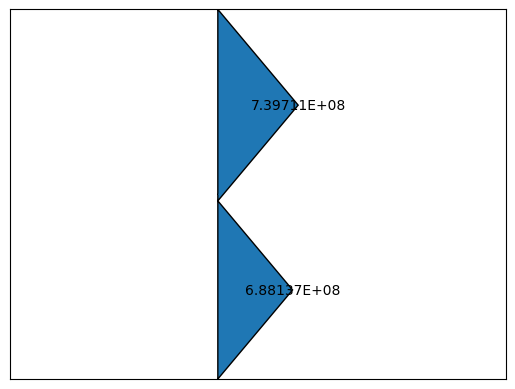

In [14]:
# Sankey.add()

Sankey(flows = [df['HP_Q_Supplied'].sum(), df['chp_supply'].sum()], orientations = [0,0]).finish()

In [15]:
a = 10
b = 15


In [16]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["Heat Pump", "CHP", "Heat Load"],
      color = "blue"
    ),
    link = dict(
      source = [0, 1], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [2, 2],
      value = [df['HP_Q_Supplied'].sum(), df['chp_supply'].sum()]
  ))])

fig.show()

In [17]:
# pip install nbformat

rt = 20
cp = 4186
Qflows = ['Q.hp_hwt1', 'Q.hwt0_hwt1', 'Q.hwt1_hwt2', 'Q.hwt2_sh', 'Q.sh_hwt0', 'Q.hwt0_hp', 'Q.chp_hwt2', 'Q.hwt2_chp']
massflows = ['HP_cond_m', 'HWTSim0_heatout_F', 'HWTSim1_heatout_F','HWTSim2_heatout_F','HWTSim0_heatin_F','HWTSim0_hp_out_F', 'CHP_mdot', 'CHP_mdot']
tempflows = ['HP_consT', 'HWTSim0_heatout_T','HWTSim1_heatout_T','HWTSim2_heatout_T','HWTSim0_heatin_T','HWTSim0_hp_out_T', 'CHP_tempout', 'CHP_tempin']
for x,y,z in zip(Qflows,massflows, tempflows):
    df[x] = df[y] * (df[z]-rt) * cp

## Sankey plots


### Additional columns

In [18]:
# mass flow out of tanks is -ve; so reorienting all attributes to tank attributes for a common direction notion.
# ideally: all flow in planned direction will be +ve, and reverse flow will be -ve(specially between tanks) 
#Q.hwt2_sh and 'Q.hwt0_hp' will return negative value, so just switched their directions around in the linkdict

rt = 20
cp = 4200  #since this was the cp in hplib
Qflows = ['Q.hp_hwt1', 'Q.hwt0_hwt1', 'Q.hwt1_hwt2', 'Q.hwt2_sh', 'Q.sh_hwt0', 'Q.hwt0_hp', 'Q.chp_hwt2', 'Q.hwt2_chp']
massflows = ['HWTSim1_hp_in_F', 'HWTSim1_hp_out_F', 'HWTSim2_hp_out_F','HWTSim2_heatout_F','HWTSim0_heatin_F','HWTSim0_hp_out_F', 'CHP_mdot', 'CHP_mdot']
tempflows = ['HWTSim1_hp_in_T', 'HWTSim1_hp_out_T','HWTSim2_hp_out_T','HWTSim2_heatout_T','HWTSim0_heatin_T','HWTSim0_hp_out_T', 'CHP_tempout', 'CHP_tempin']
for x,y,z in zip(Qflows,massflows, tempflows):
    df[x] = df[y] * (df[z]-rt) * cp


### Plot with more details

In [19]:
#Plot where out/fro CHP considered

fig = go.Figure(data=[go.Sankey(
    arrangement = "snap",
    valuesuffix = "Wh",
    node = dict(
      pad = 10,
    #   thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["Heat Pump", "Tank0", "Tank1", "Tank2", "Heat Load", "CHP"],
      x = [0, 0.35, 0.5, 0.65, 1,0.65],
      y = [0,0.2,0.85,0.35,-0.2, 0.8],
    #   color = "blue"
      color = ['Red', 'Orange', 'Orange', 'Orange', 'Green', 'Brown']
    ),
    link = dict(
      arrowlen = 55,
      source = [0, 1, 2,3, 4, 1,5,3], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [2, 2, 3,4, 1, 0,3,5],
      value = [(((df[x].sum())**2)**0.5)/4 for x in Qflows]
    #   curve = [0, 0, 0, 0.5, 0]
  ))])

fig.show()

In [20]:
#calculating values for the sankey plot

vals = [np.abs((df[x].sum())/4) for x in Qflows[0:6]]
vals.append(df['chp_supply'].sum()/4)

checkvals = [((df[x].sum())/4) for x in Qflows[0:6]] #just to check which are -ve
vals.append(df['chp_supply'].sum()/4)

vals2 = checkvals = [((df[x].sum())/4) for x in Qflows]

In [21]:
#To reverse source and target if negative value 

sources = []
targets = []


linkdict = [(0, 2), (1, 2), (2, 3), (4, 3), (4, 1), (0, 1)]
for i,x in enumerate(Qflows[0:6]):
    if df[x].sum() < 0:
        a = linkdict[i][1]
        b = linkdict[i][0]
    else:
        a = linkdict[i][0]
        b = linkdict[i][1]
    sources.append(a)
    targets.append(b)
sources.append(5)
targets.append(3)

In [22]:
fig = go.Figure(data=[go.Sankey(
    arrangement = "snap",
    valuesuffix = "Wh",
    node = dict(
      pad = 10,
    #   thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["Heat Pump", "Tank0", "Tank1", "Tank2", "Heat Load", "CHP"],
      x = [0, 0.35, 0.5, 0.65, 1,0.55],
      y = [0,-0.5,0.0,0.35,-0.2, -0.4],
    #   color = "blue"
      color = ['Red', 'Orange', 'Orange', 'Orange', 'Green', 'Brown']
    ),
    link = dict(
      arrowlen = 55,
      # source = [0, 1, 2,3, 4, 1,5], # indices correspond to labels, eg A1, A2, A1, B1, ...
      # target = [2, 2, 3,4, 1, 0,3],
      source = sources,
      target = targets,
      value = vals
    #   curve = [0, 0, 0, 0.5, 0]
  ))],
  layout = dict()
  )

fig.show()

### Simplified sankey

In [23]:
Qvals = ['HP_P_Required','Q.hp_hwt1', 'Q.hwt2_sh', 'Q.sh_hwt0','Q.hwt0_hp', 'chp_supply', 'CHPSim-0.CHP_0-P_el']
vals_smpl = [np.abs((df[x].sum())/4) for x in Qvals]

vals_smpl_check = [((df[x].sum())/4) for x in Qvals]

In [24]:
fig = go.Figure(data=[go.Sankey(
    arrangement = "snap",
    valuesuffix = "Wh",
    node = dict(
      pad = 10,
    #   thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ['Grid',"Heat Pump", "HST", "Heat Load", "CHP"],
      # x = [0, 0.35, 0.5, 0.65, 1,0.55],
      # y = [0,-0.5,0.0,0.35,-0.2, -0.4],
    #   color = "blue"
      color = ['Yellow', 'Red', 'Orange', 'Green', 'Brown']
    ),
    link = dict(
      arrowlen = 55,
      source = [0, 1, 2,3, 2, 4, 4], # actually not, no dynamic switching here!
      target = [1, 2, 3,2, 1, 2, 0],
      # source = sources,
      # target = targets,
      value = vals_smpl
    #   curve = [0, 0, 0, 0.5, 0]
  ))],
  layout = dict()
  )

fig.show()

In [25]:
df['HP_Q_Supplied'].sum()/(4*1000000)

184.9277025

In [26]:
629-548 + 67.2

148.2

In [27]:
df['heat_demand'].sum()/(4*1000000)

346.30044

### oversimplified sankey

In [28]:
Qvals_osimpl = ['HP_P_Required','HP_Q_Supplied', 'Q.hwt2_sh', 'chp_supply', 'CHPSim-0.CHP_0-P_el']
vals_smpl2 = [np.abs((df[x].sum())/4) for x in Qvals_osimpl]
vals_smpl2.append(vals_smpl2[4]-vals_smpl2[0])
vals_smpl2.append(vals_smpl2[1]+vals_smpl2[3]-vals_smpl2[2]) #appending electricity generation and the losses after heat pump/hst
vals_smpl2.append(np.abs(df['HP_Q_Evap'].sum()/4))

In [29]:
fig = go.Figure(data=[go.Sankey(
    arrangement = "snap",
    valuesuffix = "Wh",
    node = dict(
      pad = 10,
    #   thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ['Grid',"Heat Pump", "HST", "Heat Load", "CHP", "Electricity Gen.", "energy loss", "Environment"],
      x = [0.35, 0.0, 0.7, 0.85, 0.25, 0.95,0.95, 0.2],
      y = [0.5,0,0.3,0,-0.5,0.9,-2,0.7],
    #   color = "blue"
      color = ['Yellow', 'rgba(5, 0, 189, 0.8)', 'rgba(0, 0, 189, 0.8)', 'Green', 'Brown', 'rgba(0, 168, 0, 0.5)', 'rgba(150, 200, 0, 0.8)', 'rgba(0, 200, 150, 0.8)']
    ),
    link = dict(
      arrowlen = 85,
      source = [0, 1, 2, 4, 4,0, 2, 7], # actually not, no dynamic switching here!reversed directions for hwt2_sh and hwt0_hp
      target = [1, 2, 3, 2, 0, 5, 6, 1],
      # source = sources,
      # target = targets,
      value = vals_smpl2,
      color = ['rgba(0, 168, 0, 0.5)', 'rgba(0, 0, 189, 0.5)', 'rgba(0, 0, 189, 0.5)', 'rgba(137, 0, 189, 0.5)', 'rgba(0, 168, 0, 0.5)', 'rgba(0, 168, 0, 0.5)', 'rgba(143, 0, 43, 0.9)','rgba(0, 200, 150, 0.5)']
    #   curve = [0, 0, 0, 0.5, 0]
  ))],
  layout = dict()
  )

fig.show()

In [30]:
# fig = go.Figure(data=[go.Sankey(
#     arrangement = "snap",
#     valuesuffix = "Wh",
#     node = dict(
#       pad = 10,
#     #   thickness = 20,
#       line = dict(color = "black", width = 0.5),
#       label = ["Heat Pump", "Tank0", "Tank1", "Tank2", "Heat Load", 'Q.chp_hwt2', 'Q.hwt2_chp'],
#       x = [0, 0.35, 0.5, 0.65, 1],
#       y = [0,0.2,0.85,0.35,-0.2],
#     #   color = "blue"
#       color = ['Red', 'Orange', 'Orange', 'Orange', 'Green']
#     ),
#     link = dict(
#       arrowlen = 55,
#       source = [0, 1, 2,3, 4, 1], # indices correspond to labels, eg A1, A2, A1, B1, ...
#       target = [2, 2, 3,4, 1, 0],
#       value = [((df[x].sum())**2)**0.5 for x in Qflows]
#     #   curve = [0, 0, 0, 0.5, 0]
#   ))])

# fig.show()

In [31]:
df['HP_Q_Evap'].sum()/4

-130115432.4894782

In [43]:
df.loc['2022-01-01 00:00:00':'2022-01-01 00:04:00','CHP_Pth']

date
2022-01-01 00:00:00        0.0
2022-01-01 00:01:00        0.0
2022-01-01 00:02:00     1840.0
2022-01-01 00:03:00     7450.0
2022-01-01 00:04:00    14200.0
Name: CHP_Pth, dtype: float64

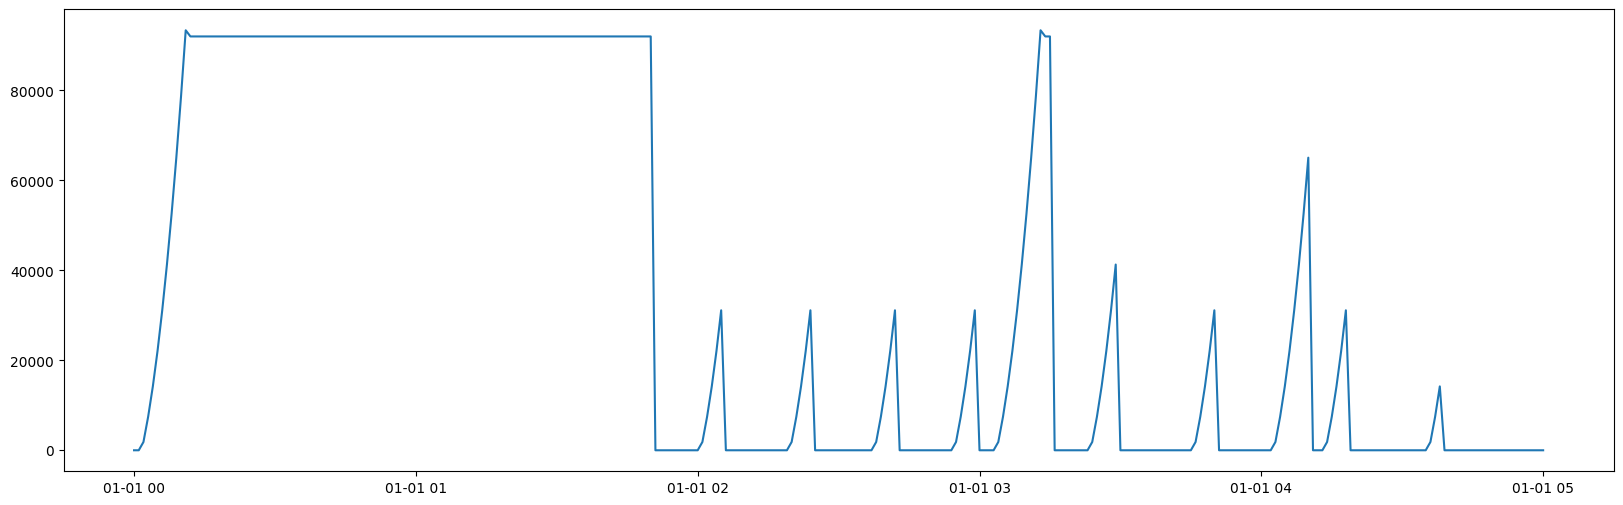

In [49]:
plt.figure(figsize = [20,6])
plt.plot(df.loc['2022-01-01 00:00:00':'2022-01-01 05:00:00','CHP_Pth'])

In [51]:
#The small kinks at the top occur when switching to P_nom after the 11th minute, measerd data and the chp reg model goes upto 100Kw.

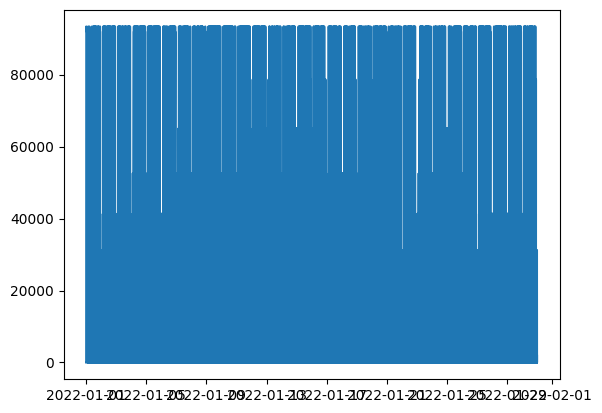

In [38]:
plt.plot(df['CHP_Pth'])